In [4]:
!pip install keras_tuner

  Using cached tensorboard-2.5.0-py3-none-any.whl (6.0 MB)
  Using cached google_auth-1.32.1-py2.py3-none-any.whl (147 kB)
  Using cached tensorboard_data_server-0.6.1-py3-none-any.whl (2.4 kB)
  Using cached protobuf-3.17.3-cp38-cp38-win_amd64.whl (909 kB)
  Using cached tensorboard_plugin_wit-1.8.0-py3-none-any.whl (781 kB)
  Using cached google_auth_oauthlib-0.4.4-py2.py3-none-any.whl (18 kB)
  Using cached absl_py-0.13.0-py3-none-any.whl (132 kB)
  Using cached Markdown-3.3.4-py3-none-any.whl (97 kB)
  Using cached cachetools-4.2.2-py3-none-any.whl (11 kB)
  Using cached rsa-4.7.2-py3-none-any.whl (34 kB)
  Using cached pyasn1_modules-0.2.8-py2.py3-none-any.whl (155 kB)
  Using cached requests_oauthlib-1.3.0-py2.py3-none-any.whl (23 kB)
  Using cached pyasn1-0.4.8-py2.py3-none-any.whl (77 kB)
  Using cached oauthlib-3.1.1-py2.py3-none-any.whl (146 kB)
  Created wheel for kt-legacy: filename=kt_legacy-1.0.3-py3-none-any.whl size=9562 sha256=41de59fa5f1ac739982b0fabde8345049e1efc1197

In [ ]:
import pandas as pd
import numpy as np
import gensim.downloader as api
import joblib
import tensorflow as tf
import tensorflow.keras.backend as K
from keras.callbacks import EarlyStopping, ModelCheckpoint
import time
import keras_tuner
from keras_tuner.tuners import RandomSearch
from keras_tuner.engine.hyperparameters import HyperParameters
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold
from keras.layers import LSTM, Dense, Bidirectional, Input,Dropout,BatchNormalization, CuDNNGRU, CuDNNLSTM
import keras_tuner as kt
import keras
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt

In [2]:
train = pd.read_csv('../Data/processed/train.csv')
test = pd.read_csv('../Data/processed/test.csv')
train['X'] = train['X'].apply(eval)
train['y'] = train['y'].apply(eval)
test['X'] = test['X'].apply(eval)
test['y'] = test['y'].apply(eval)

In [3]:
X_train = np.vstack(train['X'].values)
y_train = np.vstack(train['y'].values)
X_test = np.vstack(test['X'].values)
y_test = np.vstack(test['y'].values)

In [4]:
X_test.shape

(31888, 200)

In [7]:
import gensim.downloader
emb = gensim.downloader.load('glove-twitter-50')

In [8]:
tokenizer = joblib.load('./Tokenizer/tok.joblib')
word2idx = tokenizer.word_index
max_vocab_size = 20000
embedding_dim = 50
num_words = min(max_vocab_size, len(word2idx) + 1)


In [9]:
def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))


In [5]:
#AQUI EMPIEZA EL HIPERPARAMETER TUNING

In [6]:
from keras_tuner.tuners import RandomSearch
from keras_tuner.engine.hyperparameters import HyperParameters 
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score

In [98]:
class CVTuner(keras_tuner.engine.tuner.Tuner): 

    def __init__(self, data_cv, goal, hypermodel,oracle, proj_name, directory, overwrite):    
                self.data_cv = data_cv  
                self.goal = goal
                self.trial_scores = []
                keras_tuner.engine.tuner.Tuner.__init__(self, hypermodel=hypermodel, oracle=oracle, project_name = proj_name,
                                                       directory=directory, overwrite=overwrite)


    def run_trial(self, trial, x, y, batch_size=32, epochs=1):
    
        val_f1 = []
        val_auc= []
        val_acc = []

        for train_indices, test_indices in self.data_cv.split(x, y):
            
            x_train, x_test = x[train_indices], x[test_indices]
            y_train, y_test = y[train_indices], y[test_indices]

            model = self.hypermodel.build(trial.hyperparameters)  

            callback=[keras.callbacks.EarlyStopping(monitor=self.goal, mode='max', patience=2)]

            model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs,callbacks = callback)
            y_pred = model.predict(x_test)
            f1 = model.evaluate(x_test, y_test)
            auc = roc_auc_score(y_test,y_pred, average='weighted')
            acc = accuracy_score(y_test,np.round(y_pred))
            val_auc.append(auc)
            val_f1.append(f1)
            val_acc.append(acc)
        
        val_f1 = np.array(val_f1)[:,1]
        val_auc = np.array(val_auc)
        val_acc = np.array(val_acc)
        self.trial_scores.append({'id':trial.trial_id,
                                'hyperparams':trial.hyperparameters.values,
                                'f1': np.mean(val_f1),
                                'f1_std': np.std(val_f1),
                                'Roc_auc': np.mean(val_auc),
                                'Roc_auc_std': np.std(val_auc),
                                'Accuracy': np.mean(val_acc),
                                'Accuracy_std': np.std(val_acc)
                                 })

        self.oracle.update_trial(trial.trial_id, {self.goal: np.mean(val_f1)})
        self.save_model(trial.trial_id, model)

In [102]:
cv = MultilabelStratifiedKFold(n_splits=5)
joblib.dump(cv, './cv/cv.joblib')

['./cv/cv.joblib']

In [100]:
def build_model_Simple(hp):
    word_index = tokenizer.word_index
    embedding_matrix = np.empty((num_words,embedding_dim))
    for word, i in word_index.items():
        if i>=max_vocab_size:
          break
        try:
            embedding_matrix[i] = emb.get_vector(word)
        except:
            
            continue;
    model = ... ##Your code Here
    return model

In [103]:
tuner_Simple = CVTuner(
                    data_cv= cv,
                    goal = 'f1',
                    hypermodel=build_model_Simple,
                    oracle=keras_tuner.oracles.BayesianOptimizationOracle(
                    objective=kt.Objective('f1',direction = "max"),
                        max_trials=5                  
                    ),
                    directory='./experiments/',
                    proj_name = 'simplernn',
                    overwrite=False
                    )
tuner_Simple.search(X_train, y_train, 128, epochs=3)

Trial 5 Complete [00h 31m 46s]
f1: 0.4813816905021667

Best f1 So Far: 0.49923574924468994
Total elapsed time: 02h 41m 20s
INFO:tensorflow:Oracle triggered exit


In [104]:
pd.DataFrame(tuner_Simple.trial_scores)

,id,hyperparams,f1,f1_std,Roc_auc,Roc_auc_std,Accuracy,Accuracy_std
0,727f341ff8e33a7cf5d073bb8bfd757e,"{'input_units': 140, 'Dense_units': 30}",0.492363,0.015880,0.942081,0.004595,0.910718,0.001818
1,7590506718fe156b307c743da8d273dd,"{'input_units': 200, 'Dense_units': 20}",0.451275,0.057606,0.935533,0.012771,0.908476,0.002270
2,331298fd999c8056791fc2b3f818df63,"{'input_units': 140, 'Dense_units': 10}",0.499236,0.038593,0.951144,0.004175,0.910796,0.001939
3,3ffab6e6fbedc2cc024f30fe7e0166ad,"{'input_units': 180, 'Dense_units': 10}",0.451514,0.088417,0.946456,0.009838,0.909119,0.002118
4,f594af29e851d674eff5eb5d9e9718ec,"{'input_units': 100, 'Dense_units': 50}",0.481382,0.035742,0.947996,0.008538,0.909856,0.001363


In [105]:
simpleModel = tuner_Simple.get_best_models()[0]
simpleModel.save('models/simplernn_rnn.h5')
simpleModel.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 200, 50)           1000000   
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 200, 50)           0         
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 140)               26740     
_________________________________________________________________
dense (Dense)                (None, 10)                1410      
_________________________________________________________________
dropout (Dropout)            (None, 10)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 66        
Total params: 1,028,216
Trainable params: 28,216
Non-trainable params: 1,000,000
_________________________________________

In [99]:
def build_model_LSTM(hp):
    word_index = tokenizer.word_index
    embedding_matrix = np.empty((num_words,embedding_dim))
    for word, i in word_index.items():
        if i>=max_vocab_size:
          break
        try:
            embedding_matrix[i] = emb.get_vector(word)
        except:
            
            continue;
    model = ... # Your code Here 
    return model

In [107]:
tuner_LSTM = CVTuner(
                    data_cv= cv,
                    goal = 'f1',
                    hypermodel=build_model_LSTM,
                    oracle=keras_tuner.oracles.BayesianOptimizationOracle(
                    objective=kt.Objective('f1',direction = "max"),
                        max_trials=5                 
                    ),
                    directory='./experiments/',
                    proj_name = 'lstm',
                    overwrite=False
                    )
tuner_LSTM.search(X_train, y_train, 128, epochs=3)

Trial 5 Complete [00h 05m 13s]
f1: 0.5932714223861695

Best f1 So Far: 0.6134765386581421
Total elapsed time: 00h 27m 10s
INFO:tensorflow:Oracle triggered exit


In [108]:
pd.DataFrame(tuner_LSTM.trial_scores)

,id,hyperparams,f1,f1_std,Roc_auc,Roc_auc_std,Accuracy,Accuracy_std
0,26e417b2d1cfd3e6b7b055f7658fbf4c,"{'input_units': 160, 'Dense_units': 40}",0.592694,0.015204,0.972949,0.001232,0.917006,0.001276
1,b84f4e3ed4766fef517e1e241876ec7e,"{'input_units': 140, 'Dense_units': 30}",0.613477,0.007131,0.973347,0.001586,0.915947,0.000888
2,d74d49ba167ccf17932547f2f0075730,"{'input_units': 200, 'Dense_units': 30}",0.592609,0.024769,0.973072,0.001707,0.916982,0.001386
3,20a32db5b8bb7031884b0e48a54ad526,"{'input_units': 180, 'Dense_units': 30}",0.593942,0.017847,0.973918,0.000998,0.917280,0.001661
4,6ee86cf40d52f9274f2d0704b35c6828,"{'input_units': 100, 'Dense_units': 20}",0.593271,0.020700,0.972290,0.001695,0.917053,0.001234


In [109]:
lstmModel = tuner_LSTM.get_best_models()[0]
lstmModel.save('models/lstm_rnn.h5')
lstmModel.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 200, 50)           1000000   
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 200, 50)           0         
_________________________________________________________________
lstm (LSTM)                  (None, 140)               106960    
_________________________________________________________________
dense (Dense)                (None, 30)                4230      
_________________________________________________________________
dropout (Dropout)            (None, 30)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 186       
Total params: 1,111,376
Trainable params: 111,376
Non-trainable params: 1,000,000
________________________________________

In [112]:
def build_model_bidirectional_simple(hp):
    word_index = tokenizer.word_index
    embedding_matrix = np.empty((num_words,embedding_dim))
    for word, i in word_index.items():
        if i>=max_vocab_size:
          break
        try:
            embedding_matrix[i] = emb.get_vector(word)
        except:
            
            continue;
    model = .... #Your code here
    return model

In [126]:
tuner_simple_bidir = CVTuner(
                    data_cv= cv,
                    goal = 'f1',
                    hypermodel=build_model_GRU,
                    oracle=keras_tuner.oracles.BayesianOptimizationOracle(
                    objective=kt.Objective('f1',direction = "max"),
                        max_trials=5                 
                    ),
                    directory='./experiments/',
                    proj_name = 'bidirectional_simplernn',
                    overwrite=False
                    )
tuner_simple_bidir.search(X_train, y_train, 128, epochs=3)

Trial 5 Complete [01h 46m 38s]
f1: 0.5815940976142884

Best f1 So Far: 0.6118112802505493
Total elapsed time: 12h 24m 57s
INFO:tensorflow:Oracle triggered exit


In [127]:
pd.DataFrame(tuner_simple_bidir.trial_scores)

,id,hyperparams,f1,f1_std,Roc_auc,Roc_auc_std,Accuracy,Accuracy_std
0,b7e7f841a4479c772ac057a4edc37513,"{'input_units': 180, 'Dense_units': 20}",0.609482,0.026291,0.974023,0.001036,0.916355,0.001487
1,d9b10ae046fa5bdd416c376bf66e6baa,"{'input_units': 200, 'Dense_units': 10}",0.580826,0.016576,0.972954,0.001082,0.917359,0.000706
2,dcb2185e2b12300c2e45ca03bd12aa6c,"{'input_units': 140, 'Dense_units': 20}",0.599561,0.014252,0.974160,0.001873,0.917288,0.001122
3,962f210370db6c8cc839a5c3953e2926,"{'input_units': 120, 'Dense_units': 40}",0.611811,0.020767,0.975010,0.000752,0.917335,0.001200
4,be35d96551ff7cb44a687a4917ee0925,"{'input_units': 100, 'Dense_units': 10}",0.581594,0.030801,0.972989,0.001457,0.915869,0.001170


In [129]:
simple_bidir_Model = tuner_simple_bidir.get_best_models()[0]
simple_bidir_Model.save('models/bidirectional_simplernn.h5')
simple_bidir_Model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 50)          1000000   
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, None, 50)          0         
_________________________________________________________________
gru (GRU)                    (None, 120)               61920     
_________________________________________________________________
dense (Dense)                (None, 40)                4840      
_________________________________________________________________
dropout (Dropout)            (None, 40)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 246       
Total params: 1,067,006
Trainable params: 67,006
Non-trainable params: 1,000,000
_________________________________________

In [130]:
def build_model_bidirectional_lstm(hp):
    word_index = tokenizer.word_index
    embedding_matrix = np.empty((num_words,embedding_dim))
    for word, i in word_index.items():
        if i>=max_vocab_size:
          break
        try:
            embedding_matrix[i] = emb.get_vector(word)
        except:
            
            continue;
    model = ... #Your code here
    return model

In [131]:
tuner_lstm_bidir = CVTuner(
                    data_cv= cv,
                    goal = 'f1',
                    hypermodel=build_model_bidirectional_lstm,
                    oracle=keras_tuner.oracles.BayesianOptimizationOracle(
                    objective=kt.Objective('f1',direction = "max"),
                        max_trials=5                 
                    ),
                    directory='./experiments/',
                    proj_name = 'bidirectional_lstm',
                    overwrite=False
                    )
tuner_lstm_bidir.search(X_train, y_train, 128, epochs=3)

Trial 5 Complete [00h 09m 24s]
f1: 0.5817522764205932

Best f1 So Far: 0.6067933559417724
Total elapsed time: 00h 45m 13s
INFO:tensorflow:Oracle triggered exit


In [132]:
pd.DataFrame(tuner_lstm_bidir.trial_scores)

,id,hyperparams,f1,f1_std,Roc_auc,Roc_auc_std,Accuracy,Accuracy_std
0,6800a8de5aa2cf31ad515ff5ab81ca79,"{'input_units': 120, 'Dense_units': 50}",0.601179,0.025023,0.974038,0.001790,0.916371,0.001741
1,e71a33757ab0786baa314e9efb4a75b7,"{'input_units': 140, 'Dense_units': 40}",0.606793,0.029606,0.973162,0.000641,0.913972,0.003264
2,82cde8b0c944ed575520d173d24f09aa,"{'input_units': 180, 'Dense_units': 40}",0.504029,0.227724,0.957147,0.033498,0.912890,0.007319
3,220f74f1d48f542743bdef9541215f8e,"{'input_units': 200, 'Dense_units': 10}",0.572545,0.048869,0.971102,0.001333,0.915187,0.001287
4,7ae27e52c0b19ec62d1731a789ac0f53,"{'input_units': 160, 'Dense_units': 20}",0.581752,0.029449,0.973074,0.000954,0.916771,0.000912


In [133]:
lstm_bidir_Model = tuner_lstm_bidir.get_best_models()[0]
lstm_bidir_Model.save('models/bidirectional_lstm.h5')
lstm_bidir_Model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 200, 50)           1000000   
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 200, 50)           0         
_________________________________________________________________
bidirectional (Bidirectional (None, 280)               213920    
_________________________________________________________________
dense (Dense)                (None, 40)                11240     
_________________________________________________________________
dropout (Dropout)            (None, 40)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 246       
Total params: 1,225,406
Trainable params: 225,406
Non-trainable params: 1,000,000
________________________________________

In [54]:
def build_lstm_best_model():
    word_index = tokenizer.word_index
    embedding_matrix = np.empty((num_words,embedding_dim))
    for word, i in word_index.items():
        if i>=max_vocab_size:
          break
        try:
            embedding_matrix[i] = emb.get_vector(word)
        except:
            continue
            
    model = ... #Your code here
    return model

In [97]:
class CustomDataValidation(keras.callbacks.Callback):
    def __init__(self, x=None, y=None):
        self.x = x
        self.y = y
    def f1(self, y_true, y_pred):
        def recall(y_true, y_pred):
            """Recall metric.

            Only computes a batch-wise average of recall.

            Computes the recall, a metric for multi-label classification of
            how many relevant items are selected.
            """
            true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
            possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
            recall = true_positives / (possible_positives + K.epsilon())
            return recall

        def precision(y_true, y_pred):
            """Precision metric.

            Only computes a batch-wise average of precision.

            Computes the precision, a metric for multi-label classification of
            how many selected items are relevant.
            """
            true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
            predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
            precision = true_positives / (predicted_positives + K.epsilon())
            return precision
        precision = precision(y_true, y_pred)
        recall = recall(y_true, y_pred)
        return 2*((precision*recall)/(precision+recall+K.epsilon()))
    def on_epoch_end(self, epoch, logs=None):
        y_pred = np.round(self.model.predict(self.x))
        self.y = tf.convert_to_tensor(self.y, dtype=tf.float64)
        y_pred = tf.convert_to_tensor(y_pred, dtype=tf.float64)
        f1_s = self.f1(self.y, y_pred)
        logs["f1_val_cust"] = f1_s
        print(f'f1_val_cust:{f1_s}')
        return

In [101]:
f_model = build_lstm_best_model()
es = EarlyStopping(monitor='f1_val_cust', mode='max', patience=5, verbose=1)
history = f_model.fit(X_train, y_train, batch_size=128, epochs=100, callbacks=[CustomDataValidation(X_test, y_test), es])

Epoch 1/100
997/997 [==============================] - 24s 23ms/step - loss: 0.0840 - f1: 0.5320
f1_val_cust:0.6590282085582988
Epoch 2/100
997/997 [==============================] - 22s 22ms/step - loss: 0.0624 - f1: 0.6401
f1_val_cust:0.7025259054651847
Epoch 3/100
997/997 [==============================] - 20s 21ms/step - loss: 0.0599 - f1: 0.6553
f1_val_cust:0.709376957862062
Epoch 4/100
997/997 [==============================] - 22s 22ms/step - loss: 0.0569 - f1: 0.6690
f1_val_cust:0.7039316592679934
Epoch 5/100
997/997 [==============================] - 22s 22ms/step - loss: 0.0555 - f1: 0.6745
f1_val_cust:0.7138614164008681
Epoch 6/100
997/997 [==============================] - 19s 19ms/step - loss: 0.0539 - f1: 0.6857
f1_val_cust:0.7187752627715868
Epoch 7/100
997/997 [==============================] - 20s 20ms/step - loss: 0.0525 - f1: 0.6918
f1_val_cust:0.7231852589282541
Epoch 8/100
997/997 [==============================] - 20s 20ms/step - loss: 0.0514 - f1: 0.6977
f1_val_c

In [102]:
y_pred = f_model.predict(X_test)
f1_score(y_test, np.round(y_pred), average='weighted')

0.7320506351650181

Train: 0.799, Test: 0.732


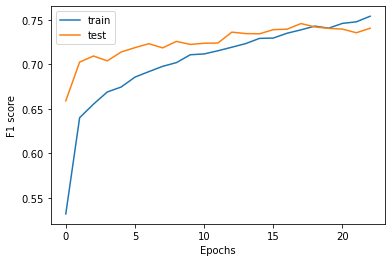

In [106]:
train_acc = f1_score(y_train, np.round(f_model.predict(X_train)), average='weighted')
test_acc = f1_score(y_test, np.round(f_model.predict(X_test)), average='weighted')
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))
# plot training history
plt.plot(history.history['f1'], label='train')
plt.plot(history.history['f1_val_cust'], label='test')
plt.xlabel('Epochs')
plt.ylabel('F1 score')
plt.legend()
plt.show()

In [105]:
f_model.save('models/lstm_final_model.h5')